In [1]:
import torch
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import transforms, ops
from torchvision.models import vgg19
from ultralytics import YOLO

from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cv2

import os
from tqdm import tqdm
from sklearn.model_selection import KFold


import datasets
# import models

In [2]:
class YoloModel(YOLO):
    def __init__(self, *args, **kwargs):
        super(YoloModel, self).__init__(*args, **kwargs)
    def __str__(self):
        return ""
    def __repr__(self):
        return ""


#Currently Using
class roiVGGYoloWithGradCam(torch.nn.Module):
    def __init__(self, numROIs: int, tsfms):
        super(roiVGGYoloWithGradCam, self).__init__()
        #Make VGG Instance for feature extraction
        self.vgg = vgg19(weights = "DEFAULT")

        #Get layers to use for feature extraction 
        self.vggConvFeatures = self.vgg.features[:35]

        #Make yolo instance
        self.yolo = YoloModel("yolov8n.pt")

        #Create the MLP which is just a series of linear layers with relu
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(25088, 4096),
            torch.nn.ReLU(),
            torch.nn.Linear(4096, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, numROIs),
        )

        #Save the torch transforms for the YOLO model
        self.tsfms = tsfms
        #variable for the gradients used in grad cam
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, img, imgPaths):
        #extract vgg features from image
        convFeatures = self.vggConvFeatures(img)

        #define function to call during back prop
        hook = convFeatures.register_hook(self.activations_hook)

        #transform the original images such as it's compatible with the YOLO model
        yoloInput = [self.tsfms(Image.open(image)) for image in imgPaths]

        #Make YOLO predictions on images and get bounding box data
        yoloResults = [results.boxes for results in self.yolo.predict(torch.stack(yoloInput), verbose=False)]
        boundingBoxDataAllImages = self.getMappedBoundingBox(yoloResults)
        finalFMRIs = []
        indices = [] #saved indexes to use that have bounding box info from yolo
        count = 0

        #for each detected bounding box
        for boundingBoxData in boundingBoxDataAllImages:
            #if no bounding boxes, continue
            if len(boundingBoxData) == 0:
                continue

            #pool the features in the regions that overlap with a bounding box. returns a result for each detected object
            objectROIPools = ops.roi_pool(convFeatures, [boundingBoxData], output_size = (7,7)) #output shape (num objects, 512, 7, 7)
            fmriPieces = []

            #for the pooled results for each object, predict the partial fmri data
            for objectROIPool in objectROIPools:
                input = torch.flatten(objectROIPool)  #flatten data to pass into mlp, shape (1, 25088)
                fmriPieces.append(self.MLP(input)) #save partial fmri prediction

            #sum over all partial fmri data
            totalFMRI = torch.sum(torch.stack(fmriPieces), dim=0)
            finalFMRIs.append(totalFMRI)
            indices.append(count)
            count+=1
        return torch.stack(finalFMRIs), indices 

    #extract bounding box data for each of the yolo results objects
    def getMappedBoundingBox(self, yoloResults):
        mappedBoxes = []
        for result in yoloResults:
            #get normalized top left and bottom right coordinates for the bounding box
            boundingBoxData = result.xyxyn

            #Get interested cells in 7x7 matrix for ROI pooling                      topLeftX               topLeftY               bottomRightX           #bottomRightY
            boundingBoxStartX, boundingBoxStartY, boundingBoxEndX, boundingBoxEndY = boundingBoxData[:, 0], boundingBoxData[:, 1], boundingBoxData[:, 2], boundingBoxData[:, 3]

            #Transform normalized range (0 to 1) to (0 to 7)
            transformedBoundingBoxStartX, transformedBoundingBoxStartY, transformedBoundingBoxEndX, transformedBoundingBoxEndY = boundingBoxStartX * 7, boundingBoxStartY * 7, boundingBoxEndX * 7, boundingBoxEndY * 7
            startCellX = torch.floor(transformedBoundingBoxStartX)
            startCellY = torch.floor(transformedBoundingBoxStartY)
            endCellX = torch.ceil(transformedBoundingBoxEndX)
            endCellY = torch.ceil(transformedBoundingBoxEndY)
            mappedBoxes.append(torch.hstack((startCellX.reshape(-1,1), startCellY.reshape(-1,1), endCellX.reshape(-1,1), endCellY.reshape(-1,1))))
        return mappedBoxes

    def get_activation_gradient(self):
        return self.gradients

    def get_activations(self, img):
        return self.vggConvFeatures(img)

    #Overwrite functions so that the model isn't printed on server side after each call to train() or eval()
    def __str__(self):
        return ""
    def __repr__(self):
        return ""

In [3]:
#define some variables to run everything
parentDir = "C:/Users/josem/Documents/schoolWork/MQP/algonauts2023_transformers#2Leader/algonauts_2023_challenge_data/"
subj = 1

#define transforms for the images to be passed into the vgg model
tsfms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

#define transforms for the images to be passed into the YOLO model
yoloTsfms = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

#create dataset
trainingDataset = datasets.AlgonautsDataset(parentDir, subj,  transform = tsfms)

c:\Users\josem\Documents\schoolWork\MQP\Git\Brain-Scans-MQP\gradCam\datasets.py:69: RuntimeWarning: Mean of empty slice.
  vals = fmriData[:,np.where(challenge_roi)[0]].mean(axis = 1)
c:\Users\josem\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8 11 12 16 17 18 19 20 21 22 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 16 17 18 19 20 21 24 25 26 27 28 29 30]


In [4]:
#create models
vggYoloModel = roiVGGYoloWithGradCam(25, yoloTsfms).to("cuda")
#load saved best parameters
bestParams = torch.load("./savedModels/5FoldBestModelActualValid.pth", map_location="cuda")
#define the layers whose parameters I want to load into model and filter out the rest
layers_to_load = ['MLP.0.weight', 'MLP.0.bias', 'MLP.2.weight', 'MLP.2.bias', 'MLP.4.weight', 'MLP.4.bias']
filtered_state_dict = {key.lstrip("MLP."): value for key, value in bestParams.items() if any(layer in key for layer in layers_to_load)}


In [5]:
#load parameters for model MLP
vggYoloModel.MLP.load_state_dict(filtered_state_dict)


<All keys matched successfully>

In [6]:
#get the metadata for best model params
bestModelData = np.load("./resultsData/5FoldBestModelData.npy")

#Define KFold technique
k_folds = 5
skf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

#Get the validation indexes used for the fold that resulted in the best params
validationIdxs = list(skf.split(np.arange(9841)))[int(bestModelData[0])][1]
validationSubset = Subset(trainingDataset, validationIdxs)

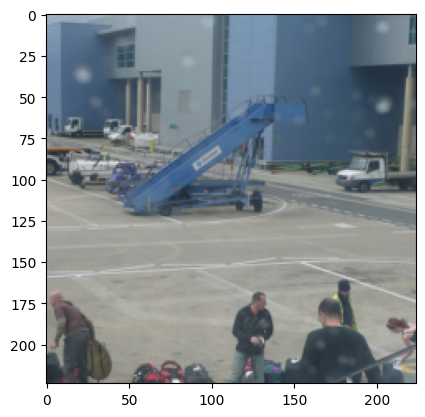

In [124]:
#Get images for testing
testData = validationSubset.__getitem__(7)
plt.imshow(testData[0].permute(1,2,0))

In [17]:
count = 0
for thing in trainingDataset.lhROIs:
    print(f"{count} {thing}", end=",  ")
    count += 1

0 V1v,  1 V1d,  2 V2v,  3 V2d,  4 V3v,  5 V3d,  6 hV4,  7 EBA,  8 FBA-1,  9 OFA,  10 FFA-1,  11 OPA,  12 PPA,  13 RSC,  14 OWFA,  15 VWFA-1,  16 VWFA-2,  17 mfs-words,  18 early,  19 midventral,  20 midlateral,  21 midparietal,  22 ventral,  23 lateral,  24 parietal,  

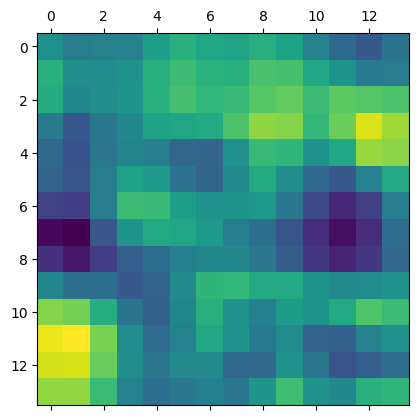

In [178]:
img = testData[0][None, :, :, :].to("cuda")
pred = vggYoloModel(img, [testData[1]])
pred[0][:, 12].backward()
gradients = vggYoloModel.get_activation_gradient()
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vggYoloModel.get_activations(img).detach()


# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().cpu()
# print(heatmap)

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

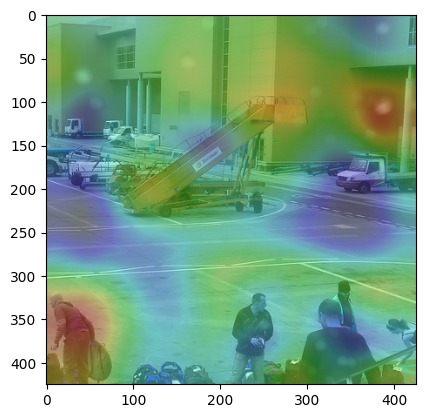

In [179]:
image = cv2.imread(testData[1])
actual = cv2.resize(heatmap.numpy(), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_CUBIC)

cmap = LinearSegmentedColormap.from_list("Jet", [(0,0,0), (0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)])

normalized_data = (actual - actual.min()) / (actual.max() - actual.min())

# Apply colormap and convert to integer array
heatmapNew = (cmap(normalized_data) * 255).astype(np.uint8)

# Apply the heatmap to the original image
superimposed_img = cv2.addWeighted(image, 0.7, heatmapNew[:,:,:3], 0.3, 0)
plt.imshow(superimposed_img)